In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
# plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [ ]:
# cloab 字體設定
import matplotlib

!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-04-07 03:42:18--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.218.138, 172.217.218.101, 172.217.218.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.218.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-04-07 03:42:18--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.127.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘taipei_sans_tc_beta.ttf’

taipei_sans_tc_beta 100%[===================>]  19.70M  --.-KB/s    in 0.09s   

2024-04-07 03:42

## 資料前處理

### 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT Aviation版
+ 時間: 2023-06-01 ~ 2023-12-31
+ 資料筆數：共 1059 篇文章

In [ ]:
#匯入資料
df = pd.read_csv('/content/drive/MyDrive/social_media_analysis/group_assignments/dataset_train.csv', encoding = 'UTF-8')
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,cici950630,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,[],209.141.52.118,2023-06-02 01:02:07,ptt
1,2,https://www.ptt.cc/bbs/Aviation/M.1685581301.A...,[分享]長榮哩程機票兌換升等後補時間,2023-06-01,nanna,Aviation,今天八點半準時打長榮客服，聽了很多語音，按了很多按鍵後，\n 按9轉客服，完全沒有等到。\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""abyssa1"", ""c...",118.163.43.79,2023-06-02 01:02:07,ptt
2,3,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...,[分享]紐西蘭航空貴賓室皇后鎮國內線ZQN,2023-06-01,Furella,Aviation,圖文網誌版:\nhttps://bitesize.tw/2018-zqn-air-new-z...,[],118.167.224.229,2023-06-02 01:02:07,ptt


### 資料清理
- 去除NA值  
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

In [ ]:
MetaData = df[df.artCatagory == 'Aviation'].copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData = MetaData.dropna(subset=['artContent'])
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...
1,2,https://www.ptt.cc/bbs/Aviation/M.1685581301.A...,[分享]長榮哩程機票兌換升等後補時間,2023-06-01,Aviation,今天八點半準時打長榮客服，聽了很多語音，按了很多按鍵後，\n 按9轉客服，完全沒有等到。\...,今天八點半準時打長榮客服聽了很多語音按了很多按鍵後按轉客服完全沒有等到里程換商務艙機票兩個位...
2,3,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...,[分享]紐西蘭航空貴賓室皇后鎮國內線ZQN,2023-06-01,Aviation,圖文網誌版:\nhttps://bitesize.tw/2018-zqn-air-new-z...,圖文網誌版年疫情前的老遊記最近發憤圖強要把全部照片圖文都整理完畢所以大量出清不喜舊遊記的朋友...


### 文章斷詞與整理

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary('/content/drive/MyDrive/social_media_analysis/group_assignments/dict.txt.big')

# 新增stopwords
with open('/content/drive/MyDrive/social_media_analysis/group_assignments/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
stopwords_manual = ["一些", "一份", "一台", "一圈", "一堆", "一定", "一家", "一人", "一天", "一小", "一大", "一帶", "一座", "一張", "一旁", "一日", "一早", "一晚", "一杯", "一條", "一次", "一段", "一種", "一起", "一趟", "一路", "一邊", "一間", "三個", "三天", "上次", "上面", "上方", "上點", "下來", "下去", "下方", "下次", "下面", "不到", "不太", "不知", "不算", "中間", "之前", "之外", "之間", "令人", "以來", "以前", "以外", "以為", "似乎", "來說", "像是", "先到", "兩個", "再次", "出現", "則是", "前方", "前面", "剛剛", "十分", "in", "XD", "一下", "一位", "一個", "一半", "一直", "一點", "下午", "不用", "主要", "之後", "今天", "今年", "今日", "他們", "以下", "以後", "來到", "入住", "內容", "出發", "分享", "前往", "包含", "包括", "可能", "吃到", "各位", "名稱", "回到", "因一", "因上", "地方", "好像", "完整", "就是", "層面", "左右", "年前", "年增", "建議", "感覺", "成為", "我們", "打打", "抵達", "持續", "指出", "提供", "搭配", "整個", "方面", "旁邊", "日期", "早上", "明天", "明年", "明日", "昨日", "是否", "晚上", "最後", "月底", "有", "有沒有", "有無", "東西", "決定", "沒", "沒有", "準備", "然後", "特別", "現在", "發現", "發生", "目前", "直接", "相關", "看到", "看看", "知道", "碰到", "維持", "聞到", "聽到", "表示", "裡面", "認為", "謝謝", "這", "這裡", "這間", "造成", "造訪", "進行", "過去", "那裡", "附近", "隔天", "離開", "需要", "顯示"]
stopWords.extend(stopwords_manual)

In [ ]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [ ]:
MetaData = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
MetaData['word'] = MetaData.sentence.apply(getToken).explode('word')

MetaData.head(3)

Building prefix dict from /content/drive/MyDrive/social_media_analysis/group_assignments/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/social_media_analysis/group_assignments/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u7234afd41a7c8425b71c38621cb87694.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u7234afd41a7c8425b71c38621cb87694.cache
Loading model cost 2.724 seconds.
DEBUG:jieba:Loading model cost 2.724 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,新聞
1,2,https://www.ptt.cc/bbs/Aviation/M.1685581301.A...,[分享]長榮哩程機票兌換升等後補時間,2023-06-01,Aviation,今天八點半準時打長榮客服，聽了很多語音，按了很多按鍵後，\n 按9轉客服，完全沒有等到。\...,今天八點半準時打長榮客服聽了很多語音按了很多按鍵後按轉客服完全沒有等到里程換商務艙機票兩個位...,想到
2,3,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...,[分享]紐西蘭航空貴賓室皇后鎮國內線ZQN,2023-06-01,Aviation,圖文網誌版:\nhttps://bitesize.tw/2018-zqn-air-new-z...,圖文網誌版年疫情前的老遊記最近發憤圖強要把全部照片圖文都整理完畢所以大量出清不喜舊遊記的朋友...,飛行


## 利用tf-idf找出重要詞彙

In [ ]:
travel_df = MetaData.copy()
travel_df.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,新聞
1,2,https://www.ptt.cc/bbs/Aviation/M.1685581301.A...,[分享]長榮哩程機票兌換升等後補時間,2023-06-01,Aviation,今天八點半準時打長榮客服，聽了很多語音，按了很多按鍵後，\n 按9轉客服，完全沒有等到。\...,今天八點半準時打長榮客服聽了很多語音按了很多按鍵後按轉客服完全沒有等到里程換商務艙機票兩個位...,想到
2,3,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...,[分享]紐西蘭航空貴賓室皇后鎮國內線ZQN,2023-06-01,Aviation,圖文網誌版:\nhttps://bitesize.tw/2018-zqn-air-new-z...,圖文網誌版年疫情前的老遊記最近發憤圖強要把全部照片圖文都整理完畢所以大量出清不喜舊遊記的朋友...,飛行


In [ ]:
# 保留需要的欄位
travel_df = travel_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
travel_df['word'] = travel_df.sentence.apply(getToken).map(' '.join)

travel_df.head()

,system_id,sentence,word
0,1,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,新聞 想到 飛行 體驗 德國 丹麥 轉機 時機 女子 恐慌 發作 倚著 艙門 拼命 搖晃 拼...
1,2,今天八點半準時打長榮客服聽了很多語音按了很多按鍵後按轉客服完全沒有等到里程換商務艙機票兩個位...,八點半 準時 長榮 客服 語音 按鍵 按轉 客服 完全 里程 商務 機票 位置 家人 候補 ...
2,3,圖文網誌版年疫情前的老遊記最近發憤圖強要把全部照片圖文都整理完畢所以大量出清不喜舊遊記的朋友...,圖文 網誌 疫情 遊記 最近 發憤圖強 照片 圖文 整理 完畢 大量出 清不喜 遊記 朋友 ...
3,4,圖文網誌版年疫情前的老遊記最近發憤圖強要把全部照片圖文都整理完畢所以大量出清不喜舊遊記的朋友...,圖文 網誌 疫情 遊記 最近 發憤圖強 照片 圖文 整理 完畢 大量出 清不喜 遊記 朋友 ...
4,5,板上前輩好關於馬印航空的小問題想請教預計搭乘馬印航空飛在轉機機票已有附了免費託運行李想加購到...,板上 前輩 航空 問題 請教 預計 搭乘 航空 飛在 轉機 機票 已有 免費 託運 行李 想...


In [ ]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(travel_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一三五,一上,一下下,一下子,一不小心,一不留神,一且,一中,一主餐,...,龍虎,龍蝦,龍騰,龍騰卡,龍騰外,龐大,龐巴迪,龔明鑫,龜山島,龜速
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1054,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
transformer = TfidfTransformer()
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一三五,一上,一下下,一下子,一不小心,一不留神,一且,一中,一主餐,...,龍虎,龍蝦,龍騰,龍騰卡,龍騰外,龐大,龐巴迪,龔明鑫,龜山島,龜速
0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1054,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1055,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1056,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 檢視結果   
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [ ]:
travel_tfidf = TFIDF_df.mean().to_frame().reset_index()
travel_tfidf.columns = ["word", "avg"]

travel_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
21213,航空,0.036031
14923,機場,0.032580
23222,貴賓室,0.023170
21200,航班,0.022974
27085,飛機,0.022660
13477,時間,0.021997
22029,行李,0.021472
21561,華航,0.020084
25768,長榮,0.019799
22848,請問,0.016957


可以看到大多數詞彙都是機場相關設施以及航空公司的名稱

#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [ ]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一三五,一上,一下下,一下子,一不小心,一不留神,一且,一中,...,龍虎,龍蝦,龍騰,龍騰卡,龍騰外,龐大,龐巴迪,龔明鑫,龜山島,龜速
0,1,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,1054,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1054,1055,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1055,1056,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1056,1057,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
29533007,1054,龜速,0.0
29533008,1055,龜速,0.0
29533009,1056,龜速,0.0
29533010,1057,龜速,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [ ]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)

    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
4829,貴賓室,76
4395,航空,62
3148,機場,60
4559,行李,51
5324,長榮,50
4471,華航,50
0,一一,42
4984,轉機,38
2794,星宇,38
1296,商務,38


由第二個方法的結果可以看出跟第一個方法的結果一樣有許多機場相關設施和航空公司的名稱，整體而言差不多。

## 透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。   

### Bigram

In [ ]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]

    return seg_list

In [ ]:
travel_bigram = MetaData.copy()

travel_bigram["word"] = travel_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
travel_bigram = travel_bigram.explode('word')

travel_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,新聞 想到
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,想到 飛行
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,飛行 體驗


#### 統計最常出現的bigram組合

In [ ]:
# 計算每個組合出現的次數
travel_bigram_count = travel_bigram['word'].value_counts().reset_index()

travel_bigram_count.sort_values('count', ascending=False).head(50)

,word,count
0,桃園 機場,267
1,長榮 航空,212
2,星宇 航空,156
3,國泰 航空,110
4,網址 內文,89
5,新聞 網址,89
6,第二 航廈,84
7,飛行 時間,84
8,後艙 組員,73
9,轉機 時間,72


### Trigram

In [ ]:
travel_trigram = MetaData.copy()

travel_trigram["word"] = travel_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
travel_trigram = travel_trigram.explode('word')

travel_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,新聞 想到 飛行
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,想到 飛行 體驗
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,飛行 體驗 德國


#### 統計最常出現的trigram組合

In [ ]:
# 計算每個組合出現的次數
travel_trigram_count = travel_trigram['word'].value_counts().reset_index()

travel_trigram_count.sort_values('count', ascending=False).head(30)

,word,count
0,新聞 網址 內文,79
1,繫緊 安全帶 燈號,38
2,圖文 好讀 網誌,27
3,好讀 網誌 純文字,26
4,飛行 時間 小時,25
5,媒體 新聞 網址,25
6,機場 第二 航廈,24
7,飛行 任務 註冊,23
8,擔任 飛行 任務,21
9,任務 註冊 番號,21


從上面的 bigram 和 trigram 的結果中，我們發現"桃園 機場"、"長榮 航空"等詞可以組合在一起，所以我們增加自定義字典來幫助斷詞能更準確。  
我們將詞彙整理好存在 dict 文件夾中的 travel_lexicon.txt 中。

### 使用自建字典

In [ ]:
# 新增吃到飽相關自定義字典
jieba.load_userdict('/content/drive/MyDrive/social_media_analysis/group_assignments/travel_lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [ ]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,新聞
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,想到
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,飛行


### Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [ ]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,新聞 想到
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,想到 飛行
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,飛行 體驗


In [ ]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(20)

[(('網址', '內文'), 90),
 (('新聞', '網址'), 88),
 (('後艙', '組員'), 73),
 (('託運', '行李'), 46),
 (('機長', '廣播'), 45),
 (('桃機', '公司'), 45),
 (('豪華', '經濟艙'), 43),
 (('預辦', '登機'), 42),
 (('東京', '羽田'), 41),
 (('安全帶', '燈號'), 40),
 (('機場', '公司'), 39),
 (('外籍', '機師'), 39),
 (('國內', '航廈'), 38),
 (('國籍', '航空'), 38),
 (('繫緊', '安全帶'), 38),
 (('國際', '航廈'), 37),
 (('經濟艙', '座位'), 37),
 (('華航', '長榮'), 37),
 (('航班', '延誤'), 34),
 (('行李', '直掛'), 34)]

In [ ]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [ ]:
# Create network plot
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率

# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

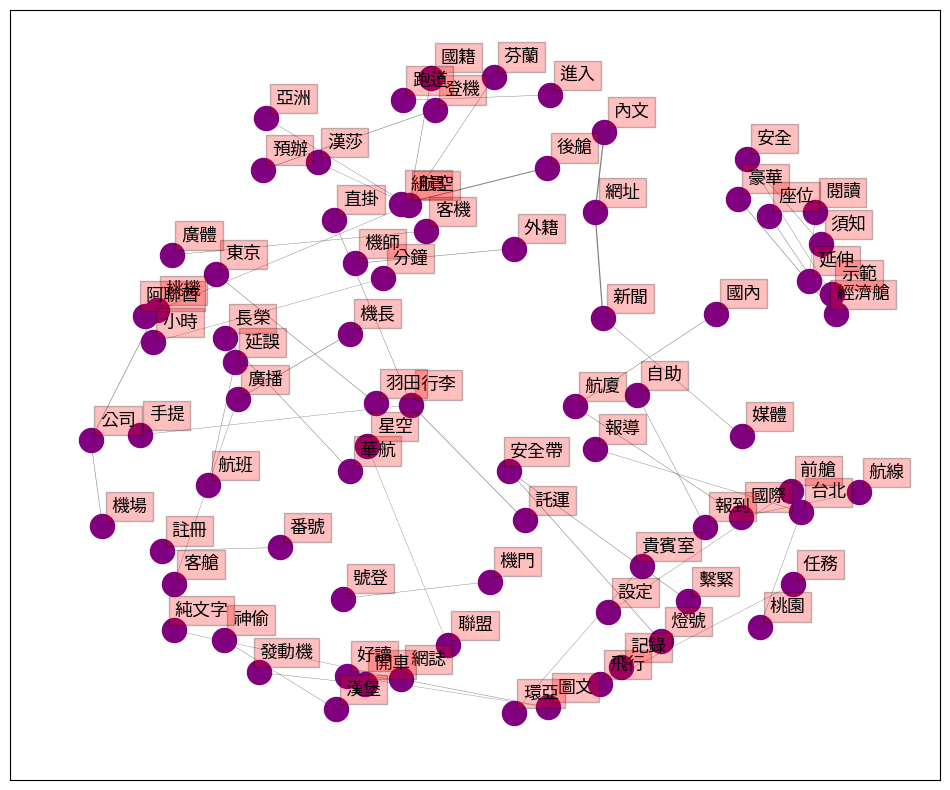

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

## Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

In [ ]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,新聞 想到 飛行 體驗 德國 丹麥 轉機 時機 女子 恐慌 發作 倚著 艙門 拼命 搖晃 拼...
1,2,https://www.ptt.cc/bbs/Aviation/M.1685581301.A...,[分享]長榮哩程機票兌換升等後補時間,2023-06-01,Aviation,今天八點半準時打長榮客服，聽了很多語音，按了很多按鍵後，\n 按9轉客服，完全沒有等到。\...,今天八點半準時打長榮客服聽了很多語音按了很多按鍵後按轉客服完全沒有等到里程換商務艙機票兩個位...,八點半 準時 長榮 客服 語音 按鍵 按轉 客服 完全 里程 商務 機票 位置 家人 候補 ...
2,3,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...,[分享]紐西蘭航空貴賓室皇后鎮國內線ZQN,2023-06-01,Aviation,圖文網誌版:\nhttps://bitesize.tw/2018-zqn-air-new-z...,圖文網誌版年疫情前的老遊記最近發憤圖強要把全部照片圖文都整理完畢所以大量出清不喜舊遊記的朋友...,圖文 網誌 疫情 遊記 最近 發憤圖強 照片 圖文 整理 完畢 大量出 清不喜 遊記 朋友 ...


In [ ]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一架,一班,下機,不錯,中國,乘客,事件,亞洲,亞航,人員,...,飛行,飛行時間,飲料,餐廳,餐飲,餐點,首爾,香港,體驗,高雄
0,0,0,0,0,0,3,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1054,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一架,一班,下機,不錯,中國,乘客,事件,亞洲,亞航,...,飛行,飛行時間,飲料,餐廳,餐飲,餐點,首爾,香港,體驗,高雄
0,一架,1.000000,0.091642,0.234733,0.019420,0.008341,0.274748,0.173202,0.137210,0.149305,...,0.243486,0.052025,0.052072,0.093984,0.082667,0.044011,0.026833,0.113443,0.124742,-0.004368
1,一班,0.091642,1.000000,0.111400,0.111488,0.077483,0.128296,0.065050,0.032967,0.004988,...,0.084344,0.046783,0.116584,0.021977,0.077073,0.127954,0.100999,0.131980,0.118008,0.118197
2,下機,0.234733,0.111400,1.000000,0.082609,-0.018953,0.341042,0.081391,0.141276,0.102774,...,0.314195,0.181184,0.110772,0.053492,0.087926,0.135337,0.085936,0.089198,0.232281,0.008000
3,不錯,0.019420,0.111488,0.082609,1.000000,0.014363,0.077233,-0.043326,0.159980,0.087801,...,0.182143,0.235194,0.294228,0.157283,0.234556,0.411766,0.015450,0.101564,0.162185,0.134502
4,中國,0.008341,0.077483,-0.018953,0.014363,1.000000,0.028651,-0.013520,0.047793,0.026170,...,0.079461,0.007650,-0.005631,-0.003430,0.007355,-0.010081,0.058108,0.071972,0.018169,0.137197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,餐點,0.044011,0.127954,0.135337,0.411766,-0.010081,0.098040,-0.009272,0.163699,0.060196,...,0.153178,0.214352,0.332237,0.169146,0.272045,1.000000,0.028840,0.114091,0.146327,0.010708
296,首爾,0.026833,0.100999,0.085936,0.015450,0.058108,-0.007018,-0.003080,0.066337,0.035320,...,0.106464,0.071822,0.035689,-0.021951,0.004784,0.028840,1.000000,0.038510,0.116326,0.125999
297,香港,0.113443,0.131980,0.089198,0.101564,0.071972,0.052513,0.087728,0.101870,-0.010572,...,0.256854,0.070770,0.079945,-0.006537,0.036593,0.114091,0.038510,1.000000,0.140853,0.129529
298,體驗,0.124742,0.118008,0.232281,0.162185,0.018169,0.044984,-0.029282,0.145472,0.091536,...,0.330263,0.191831,0.159308,0.050314,0.127877,0.146327,0.116326,0.140853,1.000000,0.095416


In [ ]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
7412,網址,內文,0.907551
63624,內文,網址,0.907551
50815,擔任,此行,0.836170
34669,此行,擔任,0.836170
9399,後艙,前艙,0.812733
29731,前艙,後艙,0.812733
20424,內文,媒體,0.809739
7268,媒體,內文,0.809739
57516,總算,發動機,0.807281
64991,發動機,總算,0.807281


### 和 「桃園機場」, 「長榮航空」 相關性最高的 10 個詞彙

In [ ]:
airport_sum = word_cor_df[(word_cor_df["word1"] == "桃園機場")].sort_values(by = ['cor'], ascending = False).head(10)
eva_sum = word_cor_df[(word_cor_df["word1"] == "長榮航空")].sort_values(by = ['cor'], ascending = False).head(10)

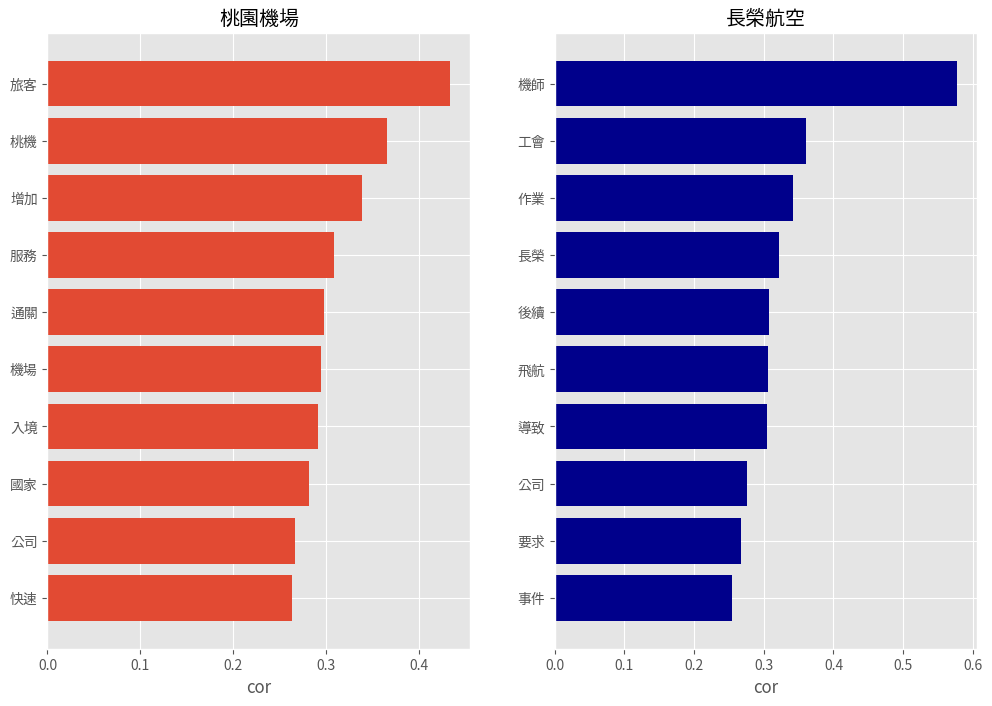

In [ ]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('桃園機場')
plt.xlabel('cor')
plt.barh(airport_sum['word2'], airport_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('長榮航空')
plt.xlabel('cor')
plt.barh(eva_sum['word2'], eva_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

由這張圖可以看出，桃園機場相關性高的詞彙大多都是服務相關的。長榮航空的部分則是跟公司內部員工相關的居多。

### 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [ ]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [ ]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,機上,乘客,0.354230
1,起飛,乘客,0.364272
2,商務,使用,0.303949
3,座位,使用,0.439452
4,搭乘,使用,0.363636
...,...,...,...
529,降落,飛行,0.519199
530,國泰,香港,0.635059
531,完成,香港,0.313372
532,降落,香港,0.328330


In [ ]:
# Create network plot
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])

# 取得edge權重
weights = [w[2]['weight']*1 for w in  g.edges(data=True)]

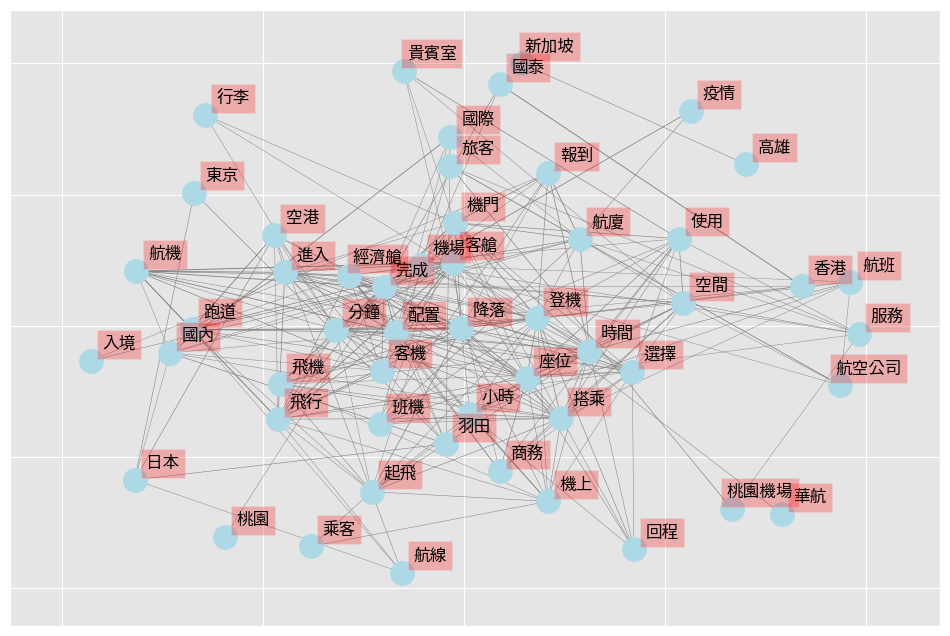

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=1)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)

plt.show()

## 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   

<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [ ]:
data_cos = data_cor.copy()
data_cos = data_cos.reset_index()
data_cos = data_cos.drop(['index'], axis = 1)
data_cos.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,新聞 想到 飛行 體驗 德國 丹麥 轉機 時機 女子 恐慌 發作 倚著 艙門 拼命 搖晃 拼...
1,2,https://www.ptt.cc/bbs/Aviation/M.1685581301.A...,[分享]長榮哩程機票兌換升等後補時間,2023-06-01,Aviation,今天八點半準時打長榮客服，聽了很多語音，按了很多按鍵後，\n 按9轉客服，完全沒有等到。\...,今天八點半準時打長榮客服聽了很多語音按了很多按鍵後按轉客服完全沒有等到里程換商務艙機票兩個位...,八點半 準時 長榮 客服 語音 按鍵 按轉 客服 完全 里程 商務 機票 位置 家人 候補 ...
2,3,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...,[分享]紐西蘭航空貴賓室皇后鎮國內線ZQN,2023-06-01,Aviation,圖文網誌版:\nhttps://bitesize.tw/2018-zqn-air-new-z...,圖文網誌版年疫情前的老遊記最近發憤圖強要把全部照片圖文都整理完畢所以大量出清不喜舊遊記的朋友...,圖文 網誌 疫情 遊記 最近 發憤圖強 照片 圖文 整理 完畢 大量出 清不喜 遊記 朋友 ...


In [ ]:
transformer = TfidfTransformer()
print(transformer)
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一架,一班,下機,不錯,中國,乘客,事件,亞洲,亞航,人員,...,飛行,飛行時間,飲料,餐廳,餐飲,餐點,首爾,香港,體驗,高雄
0,0.0,0.000000,0.0,0.000000,0.0,0.67709,0.000000,0.0,0.0,0.0,...,0.214012,0.294509,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.247102,0.0
1,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.085838,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.0,0.166684,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.285516,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.319339,0.250182,0.000000,0.0
1054,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1055,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1056,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0


計算文章間的cosine similarity

In [ ]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第三篇文章相似的文章

In [ ]:
cos_df = pd.DataFrame(cosine_matrix[2], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,0.018370
1,0.059970
2,1.000000
3,0.533562
4,0.145107
...,...
1053,0.098260
1054,0.000000
1055,0.061831
1056,0.000000


In [ ]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
2,1.000000,[分享]紐西蘭航空貴賓室皇后鎮國內線ZQN,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...
3,0.533562,[分享]紐西蘭航空貴賓室基督城國際線CHC,https://www.ptt.cc/bbs/Aviation/M.1685589145.A...
853,0.529743,Fw:[心得]越南航空--河內機場貴賓室(國際線,https://www.ptt.cc/bbs/Aviation/M.1700994714.A...
314,0.515342,[分享]普吉島機場國內貴賓室CoralLounge,https://www.ptt.cc/bbs/Aviation/M.1690460587.A...
990,0.482181,[分享]赫爾辛基芬蘭航空商務貴賓室,https://www.ptt.cc/bbs/Aviation/M.1703167852.A...
615,0.459114,Fw:[心得]越南航空-河內內排機場貴賓室(國內線),https://www.ptt.cc/bbs/Aviation/M.1696954768.A...
684,0.425633,Fw:[心得]越南航空胡志明蓮花貴賓室(國內線),https://www.ptt.cc/bbs/Aviation/M.1698171370.A...
111,0.396198,[分享]2023Skytrax全球最佳航空排名,https://www.ptt.cc/bbs/Aviation/M.1687276336.A...
164,0.394916,[問題]卡達新加坡貴賓室及報到,https://www.ptt.cc/bbs/Aviation/M.1688186476.A...
533,0.394834,[分享]CoralLounge清邁機場國際航廈貴賓室,https://www.ptt.cc/bbs/Aviation/M.1695817053.A...


第3篇文章主要是在分享紐西蘭航空的文章，所以相關性高的前幾名都是紐西蘭航空相關的文章，不過可能是因為ptt上紐西蘭航空的文章較少，因此，還是有出現像是越南航空的其他公司的文章

檢視與第35篇文章相似的文章

In [ ]:
cos_df_35 = pd.DataFrame(cosine_matrix[34], columns=['cos_similarity'])

cos_df_35 = cos_df_35.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_35.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
34,1.000000,[新聞]日女搭華航暴怒咆哮不滿空服員沒講日文,https://www.ptt.cc/bbs/Aviation/M.1685969455.A...
572,0.617979,[新聞]長榮空服員飛機上被打！外籍客霸占座位..,https://www.ptt.cc/bbs/Aviation/M.1696300836.A...
333,0.518994,[新聞]班機起飛前訊號異常300多名旅客滯留法蘭,https://www.ptt.cc/bbs/Aviation/M.1690798932.A...
120,0.491903,[新聞]日本越洋航空「鯨鯊彩繪機」首航台灣,https://www.ptt.cc/bbs/Aviation/M.1687399894.A...
76,0.435151,[新聞]她搭機返台參加喪禮...遭地勤諷「好可憐,https://www.ptt.cc/bbs/Aviation/M.1686740733.A...
632,0.424544,[情報]以色列/哈瑪斯戰爭中各國撤僑包/專機概況,https://www.ptt.cc/bbs/Aviation/M.1697269502.A...
113,0.422622,[新聞]世界旅客評桃園機場「從18名落至82名」進,https://www.ptt.cc/bbs/Aviation/M.1687315373.A...
488,0.421223,[情報]菲律賓航暫停載運所有持ESTA身份旅客赴美,https://www.ptt.cc/bbs/Aviation/M.1695041830.A...
234,0.420054,[新聞]二航廈女廁積水導致旅客摔傷送醫桃機公,https://www.ptt.cc/bbs/Aviation/M.1689415392.A...
972,0.418238,[新聞]華航「系統異常」無預警停飛,https://www.ptt.cc/bbs/Aviation/M.1702881866.A...


第35篇文章主要是分享航空相關的新聞，所以相關性較高的文章也都是新聞分享。